In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [3]:
from experiments import OptimalSensorChoice
from experiments import utilities as utils
from bayesinverse import Regression
from robiplotipy import PlotEnv
from robiplotipy.experiments.optimal_sensor_choice import (
    plot_pcm_rmse,
    plot_pcm_information,
)


/home/atmo/bin/anaconda3/envs/rmaiwald_dev/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [4]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/optimal_sensor_choice/config.yaml"
)

exp = OptimalSensorChoice(config_path)


sensors 0.0030993372201919556
emissions 3.245326593518257
transport 31.67748899757862


In [5]:
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors, exp.sensors.get_index(), exp.emissions, n_processes=30,
)


loop start 243.0582346022129
loop end 243.37636868655682


In [6]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]


In [7]:
n_mc = 2000
n_time = 24

n_sensors_list = [5, 10, 15, 20, 25, 30]
std_list = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]

data_xr = xr.Dataset(
    coords={
        "n_sensors": n_sensors_list,
        "std": std_list,
        "mc_id": list(range(n_mc)),
    }
)

data_xr["rmse"] = (
    ("n_sensors", "std", "mc_id"),
    np.zeros((len(n_sensors_list), len(std_list), n_mc)),
)
data_xr["information"] = (
    ("n_sensors", "std", "mc_id"),
    np.zeros((len(n_sensors_list), len(std_list), n_mc)),
)
data_xr["relative_improvement"] = (
    ("n_sensors", "std", "mc_id"),
    np.zeros((len(n_sensors_list), len(std_list), n_mc)),
)
data_xr["error_reduction"] = (
    ("n_sensors", "std", "mc_id"),
    np.zeros((len(n_sensors_list), len(std_list), n_mc)),
)

In [8]:
# Create a fixed list of time ids for each Monte-Carlo experiment
time_ids_list = [exp.transport.get_time_ids(time=n_time) for i in range(n_mc)]

In [9]:
for n_sensors_sample in n_sensors_list:
    print(n_sensors_sample)
    for std in std_list:
        for i in range(n_mc):
            time_ids = time_ids_list[i]
            sensor_ids = exp.sensors.get_sample_ids(n_sensors_sample)
            exp.sensors.set_std(std)
            reg = Regression(
                y=utils.stack_xr(
                    exp.K.isel(time_measurement=time_ids, sensor=sensor_ids)
                    @ exp.emissions.truth
                    + exp.sensors.get_noise(n_sensors_sample).isel(
                        time_measurement=time_ids
                    )
                ).values,
                K=utils.stack_xr(
                    exp.K.isel(time_measurement=time_ids, sensor=sensor_ids)
                ).values,
                x_prior=utils.stack_xr(exp.emissions.prior).values,
                x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
                y_covariance=utils.stack_xr(
                    exp.sensors.get_covariance().isel(
                        time_measurement=time_ids, sensor=sensor_ids
                    )
                ).values,
            )
            data_xr["information"].loc[
                dict(n_sensors=n_sensors_sample, std=std, mc_id=i)
            ] = reg.get_information_content()
            data_xr["error_reduction"].loc[
                dict(n_sensors=n_sensors_sample, std=std, mc_id=i)
            ] = reg.get_error_reduction().mean()
            x_est, _, _, _ = reg.fit()
            x_posterior = exp.emissions.to_xr(x_est)
            x_posterior = utils.unstack_xr(x_posterior) * true_emissions
            error = exp.emissions.truth_absolute - x_posterior
            rmse = np.sqrt(np.mean(error**2))
            # rmse = np.sqrt(
            #     np.mean(
            #         (
            #             exp.emissions.truth_absolute.sum(dim="source_group")
            #             - x_posterior.sum(dim="source_group")
            #         )
            #         ** 2
            #     )
            # )
            data_xr["rmse"].loc[
                dict(n_sensors=n_sensors_sample, std=std, mc_id=i)
            ] = rmse
            data_xr["relative_improvement"].loc[
                dict(n_sensors=n_sensors_sample, std=std, mc_id=i)
            ] = reg.get_relative_gain(
                exp.emissions.truth_absolute.sel(time_state=0),
                x_posterior.sel(time_state=0),
            ) * 100 


5


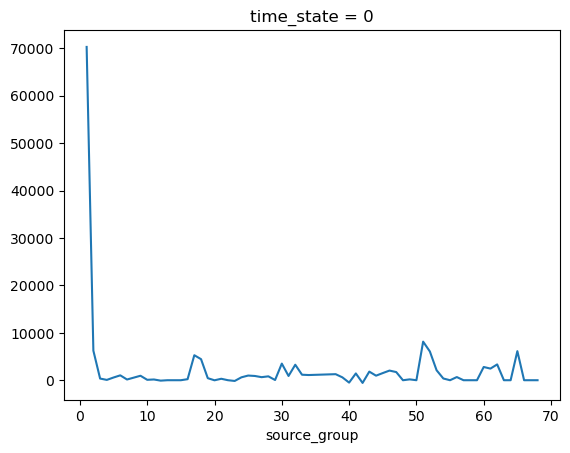

In [ ]:
x_posterior.plot()

Saving

In [11]:
exp.data["data"] = data_xr
exp.pickle_data()

FileExistsError: [Errno 17] File exists: '/home/rmaiwald/results/paper/experiments/OptimalSensorChoice/config.yaml'

In [12]:
data_xr

<xarray.Dataset>
Dimensions:               (n_sensors: 6, std: 8, mc_id: 2000)
Coordinates:
  * n_sensors             (n_sensors) int64 5 10 15 20 25 30
  * std                   (std) float64 0.1 0.5 1.0 2.0 3.0 4.0 5.0 10.0
  * mc_id                 (mc_id) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables:
    rmse                  (n_sensors, std, mc_id) float64 763.7 ... 2.465e+03
    information           (n_sensors, std, mc_id) float64 169.5 84.8 ... 45.12
    relative_improvement  (n_sensors, std, mc_id) float64 88.71 68.53 ... 63.56
    error_reduction       (n_sensors, std, mc_id) float64 68.27 36.44 ... 45.14